# Neural Networks for Handwritten Digit Recognition, Binary

### Problem Statement
You will use a neural network to recognize the hand-written digits zero and one. This Neural Network is implemented using TensorFlow and the Forward Propagation method

### Importing Packages

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import matplotlib.pyplot as plt
from autils import *
%matplotlib inline

import logging
logging.getLogger("tensorflow").setLevel(logging.ERROR)
tf.autograph.set_verbosity(0)

**Tensorflow and Keras**  
Tensorflow is a machine learning package developed by Google. In 2019, Google integrated Keras into Tensorflow and released Tensorflow 2.0. Keras is a framework developed independently by François Chollet that creates a simple, layer-centric interface to Tensorflow. This course will be using the Keras interface. 

### Dataset

You will start by loading the dataset for this task. 
- The `load_data()` function shown below loads the data into variables `X` and `y`


- The data set contains 1000 training examples of handwritten digits $^1$, here limited to zero and one.  

    - Each training example is a 20-pixel x 20-pixel grayscale image of the digit. 
        - Each pixel is represented by a floating-point number indicating the grayscale intensity at that location. 
        - The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. 
        - Each training example becomes a single row in our data matrix `X`. 
        - This gives us a 1000 x 400 matrix `X` where every row is a training example of a handwritten digit image.

$$X = 
\left(\begin{array}{cc} 
--- (x^{(1)}) --- \\
--- (x^{(2)}) --- \\
\vdots \\ 
--- (x^{(m)}) --- 
\end{array}\right)$$ 

- The second part of the training set is a 1000 x 1 dimensional vector `y` that contains labels for the training set
    - `y = 0` if the image is of the digit `0`, `y = 1` if the image is of the digit `1`.

$^1$<sub> This is a subset of the MNIST handwritten digit dataset (http://yann.lecun.com/exdb/mnist/)</sub>

In [2]:
X, y = load_data()

### Dimensions of Datasets

In [4]:
print ('The shape of X is: {} '.format((X.shape)))
print ('The shape of y is: {} '.format((y.shape)))

The shape of X is: (1000, 400) 
The shape of y is: (1000, 1) 


### Viewing Datasets

In [5]:
print ('The first element of X is: ', X[0])

The first element of X is:  [ 0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+00
  0.00000000e+00  0.00000000e+00  0.00000000e+00  0.00000000e+

In [6]:
print ('The first element of y is: ', y[0,0])
print ('The last element of y is: ', y[-1,0])

The first element of y is:  0
The last element of y is:  1


#### Visualizing the Data

You will begin by visualizing a subset of the training set. 
- In the cell below, the code randomly selects 64 rows from `X`, maps each row back to a 20 pixel by 20 pixel grayscale image and displays the images together. 
- The label for each image is displayed above the image 

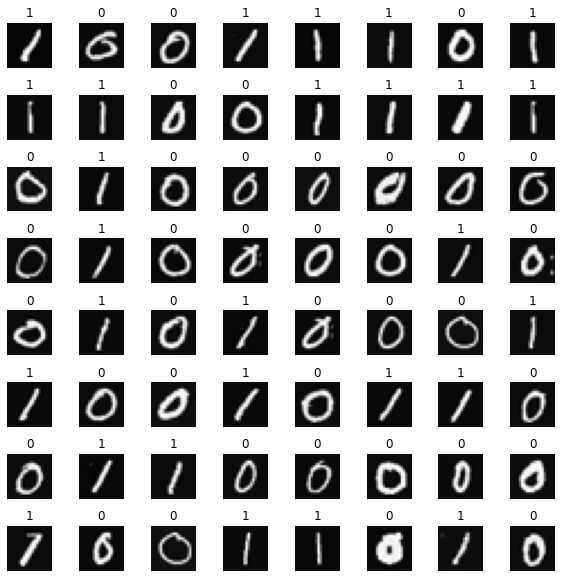

In [7]:
import warnings
warnings.filterwarnings('ignore')

m, n = X.shape

fig, axes = plt.subplots(8,8, figsize=(8,8))
fig.tight_layout(pad=0.1)

for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X[random_index].reshape((20,20)).T
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')
    
    # Display the label above the image
    ax.set_title(y[random_index,0])
    ax.set_axis_off()

### Model representation

The neural network to be used is shown in the figure below. 
- This has three dense layers with sigmoid activations.
    - Recall that our inputs are pixel values of digit images.
    - Since the images are of size $20\times20$, this gives us $400$ inputs  
    
<img src="images/C2_W1_Assign1.PNG" width="500" height="400">

- The parameters have dimensions that are sized for a neural network with $25$ units in layer 1, $15$ units in layer 2 and $1$ output unit in layer 3. 

    - Recall that the dimensions of these parameters are determined as follows:
        - If network has $s_{in}$ units in a layer and $s_{out}$ units in the next layer, then 
            - $W$ will be of dimension $s_{in} \times s_{out}$.
            - $b$ will a vector with $s_{out}$ elements
  
    - Therefore, the shapes of `W`, and `b`,  are 
        - layer1: The shape of `W1` is (400, 25) and the shape of `b1` is (25,)
        - layer2: The shape of `W2` is (25, 15) and the shape of `b2` is: (15,)
        - layer3: The shape of `W3` is (15, 1) and the shape of `b3` is: (1,)
>**Note:** The bias vector `b` could be represented as a 1-D (n,) or 2-D (n,1) array. Tensorflow utilizes a 1-D representation and this lab will maintain that convention. 
               

## Tensorflow Model Implementation


Tensorflow models are built layer by layer. A layer's input dimensions ($s_{in}$ above) are calculated for you. You specify a layer's *output dimensions* and this determines the next layer's input dimension. The input dimension of the first layer is derived from the size of the input data specified in the `model.fit` statment below. 
>**Note:** It is also possible to add an input layer that specifies the input dimension of the first layer. For example:  
`tf.keras.Input(shape=(400,)),    #specify input shape`  
We will include that here to illuminate some model sizing.

In [8]:
model = Sequential(
    [               
        tf.keras.Input(shape=(400,)),    #specify input size
        Dense(units=25, activation='sigmoid', name = 'layer1'),
        Dense(units=15, activation='sigmoid', name = 'layer2'),
        Dense(units=1, activation='sigmoid', name = 'layer3'),
        
    ], name = "my_model" 
)

In [9]:
model.summary()

Model: "my_model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Dense)              (None, 25)                10025     
                                                                 
 layer2 (Dense)              (None, 15)                390       
                                                                 
 layer3 (Dense)              (None, 1)                 16        
                                                                 
Total params: 10,431
Trainable params: 10,431
Non-trainable params: 0
_________________________________________________________________


The parameter counts shown in the summary correspond to the number of elements in the weight and bias arrays as shown below.

In [10]:
L1_num_params = 400 * 25 + 25  # W1 parameters  + b1 parameters
L2_num_params = 25 * 15 + 15   # W2 parameters  + b2 parameters
L3_num_params = 15 * 1 + 1     # W3 parameters  + b3 parameters
print("L1 params = ", L1_num_params, ", L2 params = ", L2_num_params, ",  L3 params = ", L3_num_params )

L1 params =  10025 , L2 params =  390 ,  L3 params =  16


In [11]:
[layer1, layer2, layer3] = model.layers

### Examining Weights for confirmation

In [12]:
W1,b1 = layer1.get_weights()
W2,b2 = layer2.get_weights()
W3,b3 = layer3.get_weights()
print(f"W1 shape = {W1.shape}, b1 shape = {b1.shape}")
print(f"W2 shape = {W2.shape}, b2 shape = {b2.shape}")
print(f"W3 shape = {W3.shape}, b3 shape = {b3.shape}")

W1 shape = (400, 25), b1 shape = (25,)
W2 shape = (25, 15), b2 shape = (15,)
W3 shape = (15, 1), b3 shape = (1,)


### The weights can aslo be directly accessed in their TENSOR form

In [13]:
print(model.layers[2].weights)

[<tf.Variable 'layer3/kernel:0' shape=(15, 1) dtype=float32, numpy=
array([[-7.0263565e-02],
       [ 5.4336828e-01],
       [ 3.2683837e-01],
       [ 4.6895939e-01],
       [-3.0514085e-01],
       [ 1.6203344e-02],
       [-5.0959277e-01],
       [ 3.5121524e-01],
       [ 2.0164251e-04],
       [ 1.9407791e-01],
       [-3.2840946e-01],
       [ 4.9412686e-01],
       [ 3.9384979e-01],
       [ 5.2775639e-01],
       [ 2.3156106e-01]], dtype=float32)>, <tf.Variable 'layer3/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>]


In [14]:
model.compile(
    loss=tf.keras.losses.BinaryCrossentropy(),
    optimizer=tf.keras.optimizers.Adam(0.001),
)

model.fit(
    X, y, epochs=20
)

Epoch 1/20
32/32 [==============================] - 4s 7ms/step - loss: 0.7491
Epoch 2/20
32/32 [==============================] - 0s 3ms/step - loss: 0.5571
Epoch 3/20
32/32 [==============================] - 0s 3ms/step - loss: 0.4271
Epoch 4/20
32/32 [==============================] - 0s 3ms/step - loss: 0.3098
Epoch 5/20
32/32 [==============================] - 0s 3ms/step - loss: 0.2249
Epoch 6/20
32/32 [==============================] - 0s 3ms/step - loss: 0.1703
Epoch 7/20
32/32 [==============================] - 0s 4ms/step - loss: 0.1351
Epoch 8/20
32/32 [==============================] - 0s 3ms/step - loss: 0.1113
Epoch 9/20
32/32 [==============================] - 0s 3ms/step - loss: 0.0940
Epoch 10/20
32/32 [==============================] - 0s 3ms/step - loss: 0.0812
Epoch 11/20
32/32 [==============================] - 0s 3ms/step - loss: 0.0711
Epoch 12/20
32/32 [==============================] - 0s 3ms/step - loss: 0.0631
Epoch 13/20
32/32 [==============================

### Making Predictions

To run the model on an example to make a prediction, use [Keras `predict`](https://www.tensorflow.org/api_docs/python/tf/keras/Model). The input to `predict` is an array so the single example is reshaped to be two dimensional.

The output of the model is interpreted as a probability. In the first example below, the input is a zero. The model predicts the probability that the input is a one is nearly zero. 
In the second example, the input is a one. The model predicts the probability that the input is a one is nearly one.
As in the case of logistic regression, the probability is compared to a threshold to make a final prediction.

In [15]:
prediction = model.predict(X[0].reshape(1,400))  # a zero
print(f" predicting a zero: {prediction}")
prediction = model.predict(X[500].reshape(1,400))  # a one
print(f" predicting a one:  {prediction}")

1/1 [==============================] - 0s 257ms/step
 predicting a zero: [[0.03619309]]
1/1 [==============================] - 0s 29ms/step
 predicting a one:  [[0.9852528]]


In [16]:
if prediction >= 0.5:
    yhat = 1
else:
    yhat = 0
print(f"prediction after threshold: {yhat}")

prediction after threshold: 1


### Comparing our Tensorflow predictions with the target labels

1/1 [==============================] - 0s 48ms/step


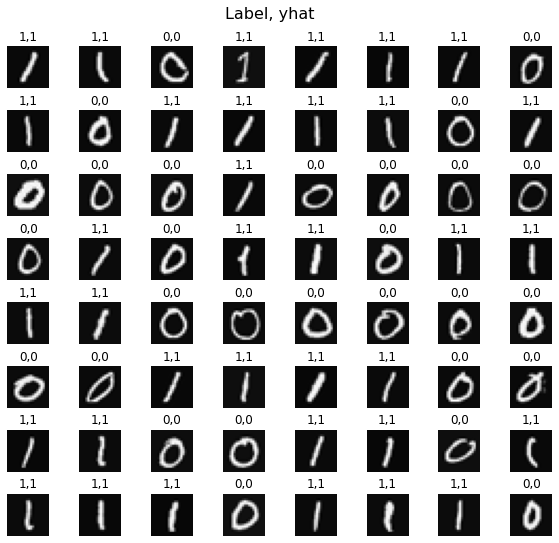

In [18]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

m, n = X.shape

fig, axes = plt.subplots(8,8, figsize=(8,8))
fig.tight_layout(pad=0.1,rect=[0, 0.03, 1, 0.92]) #[left, bottom, right, top]

for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X[random_index].reshape((20,20)).T
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')
    
    # Predict using the Neural Network
    prediction = model.predict(X[random_index].reshape(1,400))
    if prediction >= 0.5:
        yhat = 1
    else:
        yhat = 0
    
    # Display the label above the image
    ax.set_title(f"{y[random_index,0]},{yhat}")
    ax.set_axis_off()
fig.suptitle("Label, yhat", fontsize=16)
plt.show()

## Numpy Model Implementation (Forward Prop in NumPy)

It is possible to build your own dense layer using NumPy. This can then be utilized to build a multi-layer neural network. 

<img src="images/C2_W1_dense2.PNG" width="600" height="450">

In [24]:
def my_dense(a_in, W, b, g):
    """
    Computes dense layer
    Args:
      a_in (ndarray (n, )) : Data, 1 example 
      W    (ndarray (n,j)) : Weight matrix, n features per unit, j units
      b    (ndarray (j, )) : bias vector, j units  
      g    activation function (e.g. sigmoid, relu..)
    Returns
      a_out (ndarray (j,))  : j units
    """
    units = W.shape[1]
    a_out = np.zeros(units)
    for j in range(units):               
        w = W[:,j]                                    
        z = np.dot(w, a_in) + b[j]         
        a_out[j] = g(z)
    
    return(a_out)

In [26]:
# Quick Check
x_tst = 0.1*np.arange(1,3,1).reshape(2,)  # (2 features)
W_tst = 0.1*np.arange(1,7,1).reshape(2,3) # (2 input features, 3 output features)
b_tst = 0.1*np.arange(1,4,1).reshape(3,)  # (3 features)
A_tst = my_dense(x_tst, W_tst, b_tst, sigmoid)
print(A_tst)

[0.54735762 0.57932425 0.61063923]


The following cell builds a three-layer neural network utilizing the `my_dense` subroutine above.

In [29]:
def my_sequential(x, W1, b1, W2, b2, W3, b3):
    a1 = my_dense(x,  W1, b1, sigmoid)
    a2 = my_dense(a1, W2, b2, sigmoid)
    a3 = my_dense(a2, W3, b3, sigmoid)
    return(a3)

In [30]:
W1_tmp,b1_tmp = layer1.get_weights()
W2_tmp,b2_tmp = layer2.get_weights()
W3_tmp,b3_tmp = layer3.get_weights()

### Making Predictions

In [32]:
prediction = my_sequential(X[0], W1_tmp, b1_tmp, W2_tmp, b2_tmp, W3_tmp, b3_tmp )
if prediction >= 0.5:
    yhat = 1
else:
    yhat = 0
print( "yhat = ", yhat, " label= ", y[0,0]);print()

prediction = my_sequential(X[500], W1_tmp, b1_tmp, W2_tmp, b2_tmp, W3_tmp, b3_tmp )
if prediction >= 0.5:
    yhat = 1
else:
    yhat = 0
print( "yhat = ", yhat, " label= ", y[500,0])

yhat =  0  label=  0

yhat =  1  label=  1


### Comparing our predictions from both the Numpy model and the Tensorflow model

1/1 [==============================] - 0s 36ms/step


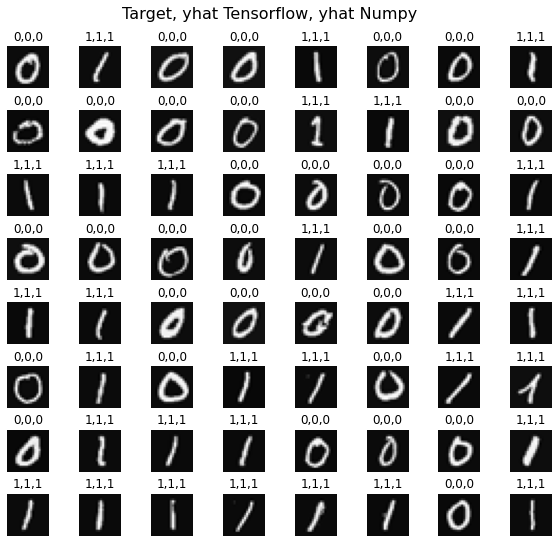

In [35]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

m, n = X.shape

fig, axes = plt.subplots(8,8, figsize=(8,8))
fig.tight_layout(pad=0.1,rect=[0, 0.03, 1, 0.92]) #[left, bottom, right, top]

for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X[random_index].reshape((20,20)).T
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')

    # Predict using the Neural Network implemented in Numpy
    my_prediction = my_sequential(X[random_index], W1_tmp, b1_tmp, W2_tmp, b2_tmp, W3_tmp, b3_tmp )
    my_yhat = int(my_prediction >= 0.5)

    # Predict using the Neural Network implemented in Tensorflow
    tf_prediction = model.predict(X[random_index].reshape(1,400))
    tf_yhat = int(tf_prediction >= 0.5)
    
    # Display the label above the image
    ax.set_title(f"{y[random_index,0]},{tf_yhat},{my_yhat}")
    ax.set_axis_off() 
fig.suptitle("Target, yhat Tensorflow, yhat Numpy", fontsize=16)
plt.show()

### Comparing our Numpy predictions with the target labels

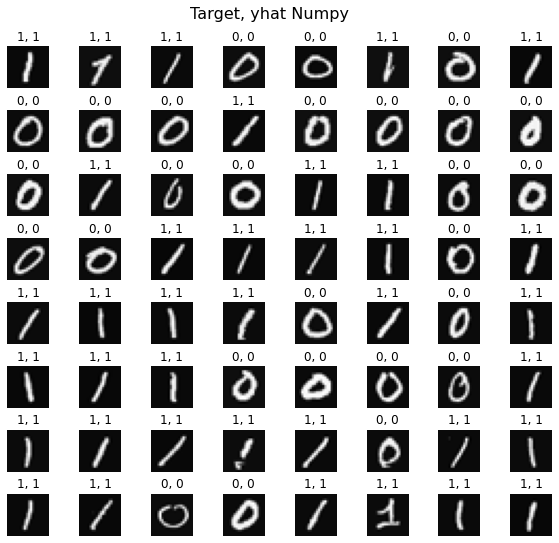

In [36]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

m, n = X.shape

fig, axes = plt.subplots(8,8, figsize=(8,8))
fig.tight_layout(pad=0.1,rect=[0, 0.03, 1, 0.92]) #[left, bottom, right, top]

for i,ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X[random_index].reshape((20,20)).T
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')
    
     # Predict using the Neural Network implemented in Numpy
    my_prediction = my_sequential(X[random_index], W1_tmp, b1_tmp, W2_tmp, b2_tmp, W3_tmp, b3_tmp )
    my_yhat = int(my_prediction >= 0.5)
    
    if my_prediction >= 0.5:
        my_yhat = 1
    else:
        my_yhat = 0
    
    # Display the label above the image
    ax.set_title(f"{y[random_index,0]}, {my_yhat}")
    ax.set_axis_off()
fig.suptitle("Target, yhat Numpy", fontsize=16)
plt.show()

## Vectorized Numpy Model Implementation (Forward Prop in NumPy)

Vector and Matrix operations can be used to speed the calculations.
Below describes a layer operation that computes the output for all units in a layer on a given input example:

<img src="images/C2_W1_VectorMatrix.PNG" width="600" height="450">

We can demonstrate this using the examples `X` and the `W1`,`b1` parameters above. We use `np.matmul` to perform the matrix multiply. Note, the dimensions of x and W must be compatible as shown in the diagram above.

In [41]:
# column vector (400,1)
x = X[0].reshape(-1,1)
z1 = np.matmul(x.T,W1) + b1  # applying matmul to (1,400) and (400,25) gives (1,25)
a1 = sigmoid(z1)
print(a1.shape)

(1, 25)


The following cell compose a new `my_dense_v` subroutine that performs the layer calculations for a matrix of examples. This will utilize `np.matmul()`. 

In [42]:
def my_dense_v(A_in, W, b, g):
    """
    Computes dense layer
    Args:
      A_in (ndarray (m,n)) : Data, m examples, n features each
      W    (ndarray (n,j)) : Weight matrix, n features per unit, j units
      b    (ndarray (1,j)) : bias vector, j units  
      g    activation function (e.g. sigmoid, relu..)
    Returns
      A_out (ndarray (m,j)) : m examples, j units
    """
    z = np.matmul(A_in, W) + b
    A_out = g(z)
    
    return(A_out)

In [44]:
# Quick Test

X_tst = 0.1*np.arange(1,9,1).reshape(4,2)  # (4 examples, 2 features)
W_tst = 0.1*np.arange(1,7,1).reshape(2,3)  # (2 input features, 3 output features)
b_tst = 0.1*np.arange(1,4,1).reshape(1,3)  # (1 input features, 3 output features)
A_tst = my_dense_v(X_tst, W_tst, b_tst, sigmoid) 
print(A_tst)

[[0.54735762 0.57932425 0.61063923]
 [0.57199613 0.61301418 0.65248946]
 [0.5962827  0.64565631 0.6921095 ]
 [0.62010643 0.67699586 0.72908792]]


The following cell builds a three-layer neural network utilizing the `my_dense_v` subroutine above.

In [47]:
def my_sequential_v(X, W1, b1, W2, b2, W3, b3):
    A1 = my_dense_v(X,  W1, b1, sigmoid)
    A2 = my_dense_v(A1, W2, b2, sigmoid)
    A3 = my_dense_v(A2, W3, b3, sigmoid)
    return(A3)

In [48]:
W1_tmp,b1_tmp = layer1.get_weights()
W2_tmp,b2_tmp = layer2.get_weights()
W3_tmp,b3_tmp = layer3.get_weights()

Let's make a prediction with the new model. This will make a prediction on *all of the examples at once*. Note the shape of the output.

In [52]:
Prediction = my_sequential_v(X, W1_tmp, b1_tmp, W2_tmp, b2_tmp, W3_tmp, b3_tmp )
Prediction.shape

(1000, 1)

We'll apply a threshold of 0.5 as before, but to all predictions at once.

In [55]:
Yhat = (Prediction >= 0.5).astype(int)
print("predict a zero: ",Yhat[0], "predict a one: ", Yhat[500])

predict a zero:  [0] predict a one:  [1]


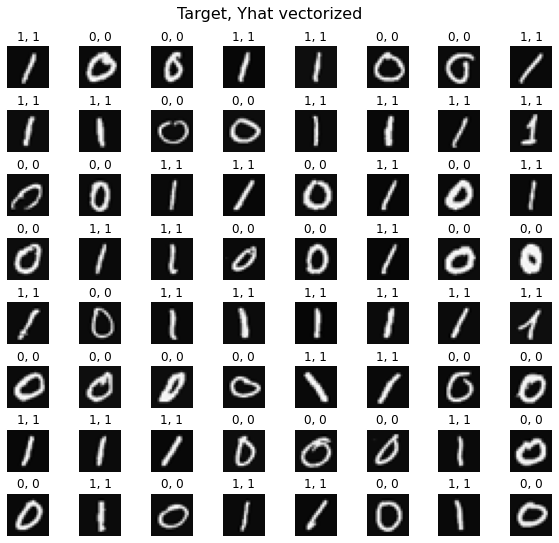

In [57]:
import warnings
warnings.filterwarnings(action='ignore', category=FutureWarning)

m, n = X.shape

fig, axes = plt.subplots(8, 8, figsize=(8, 8))
fig.tight_layout(pad=0.1, rect=[0, 0.03, 1, 0.92]) #[left, bottom, right, top]

for i, ax in enumerate(axes.flat):
    # Select random indices
    random_index = np.random.randint(m)
    
    # Select rows corresponding to the random indices and
    # reshape the image
    X_random_reshaped = X[random_index].reshape((20, 20)).T
    
    # Display the image
    ax.imshow(X_random_reshaped, cmap='gray')
   
    # Display the label above the image
    ax.set_title(f"{y[random_index,0]}, {Yhat[random_index, 0]}")
    ax.set_axis_off() 
fig.suptitle("Target, Yhat vectorized", fontsize=16)
plt.show()